> Examples

Refer: https://github.com/benedekrozemberczki/pytorch_geometric_temporal/tree/master/examples/recurrent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

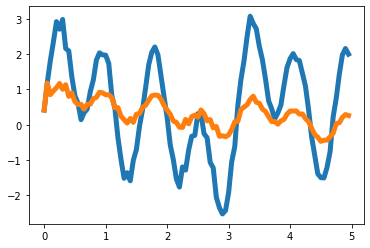

In [2]:
T = 100
t = np.arange(T)/T * 5

x = 1*np.sin(2*t)+0.5*np.random.rand(T)+np.sin(4*t)+1.5*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}

# save_data(data_dict1, './data/toy_example1.pkl')

data = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

# save_data(data1, './data/toy_example_true1.csv')

In [3]:
import itstgcn

In [4]:
loader = itstgcn.DatasetLoader(data_dict)

# GConvGRU

In [5]:
GConvGRU?

Object `GConvGRU` not found.


In [7]:
# from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = WikiMathsDatasetLoader()

# dataset = loader.get_dataset(lags=14)

# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

dataset = loader.get_dataset(lags=2)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [9]:
model = RecurrentGCN(node_features=4, filters=32)

In [10]:
model

RecurrentGCN(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
from tqdm import tqdm

# model = RecurrentGCN(node_features=14, filters=32)
model = RecurrentGCN(node_features=2, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(5)):# 50
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        mean_diff = torch.mean((y_hat-snapshot.y), dim=0)
        cost = torch.square(mean_diff)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


In [12]:
model.eval()
cost = 0
_a = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1256


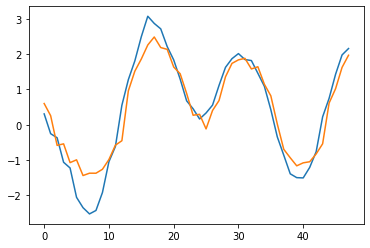

In [50]:
plt.plot([test_dataset.targets[i][0] for i in range(48)])
plt.plot(torch.tensor([_a[i].detach()[0] for i in range(48)]))

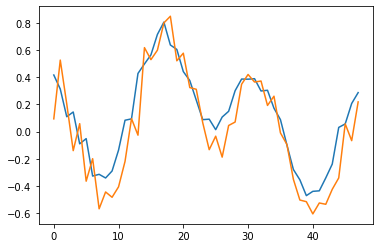

In [51]:
plt.plot([test_dataset.targets[i][1] for i in range(48)])
plt.plot(torch.tensor([_a[i].detach()[1] for i in range(48)]))

# A3GCN2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2

In [3]:
# GPU support
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

In [4]:
#Dataset
#Traffic forecasting dataset based on Los Angeles Metropolitan traffic
#207 loop detectors on highways
#March 2012 - June 2012
#From the paper: Diffusion Convolutional Recurrent Neural Network

In [10]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

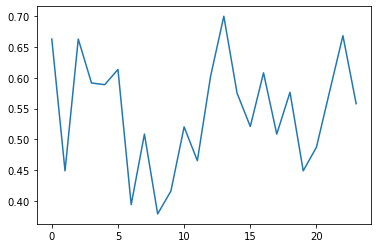

In [11]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

In [12]:
# Train test split 

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)


In [14]:
# Creating Dataloaders

train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [15]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [16]:
# Making the model 
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

In [17]:
TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [18]:
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


In [19]:
print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')  # If you notice here the Attention is a trainable parameter
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])


Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}]


In [20]:
# Loading the graph once because it's a static graph

for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;


In [23]:
# Training the model 
model.train()

for epoch in range(3): # 30
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.44013768196105957
0.44626042172312735
0.4474838371078173
0.44511159002780915
0.4446671283841133
0.4492054430147012
0.4518048374993461
0.4486549423262477
Epoch 0 train RMSE: 0.4478
0.45916826501488683
0.451208501085639
0.4479588058094184
0.4489660017192364
0.4470058409571648
0.44722517212231955
0.4471735526408468
0.4478337676823139
Epoch 1 train RMSE: 0.4471
0.45132808953523634
0.4424465082585812
0.44844810595115026
0.44880970306694506
0.44570656085014343
0.4443529421339432
0.44464062641773905
0.4452343595586717
Epoch 2 train RMSE: 0.4465


In [24]:
## Evaluation

#- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
#- The model always gets one hour and needs to predict the next hour

In [25]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)

In [26]:
print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.5491


In [27]:
### Visualization

#- The further away the point in time is, the worse the predictions get
#- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [28]:
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<AxesSubplot:>

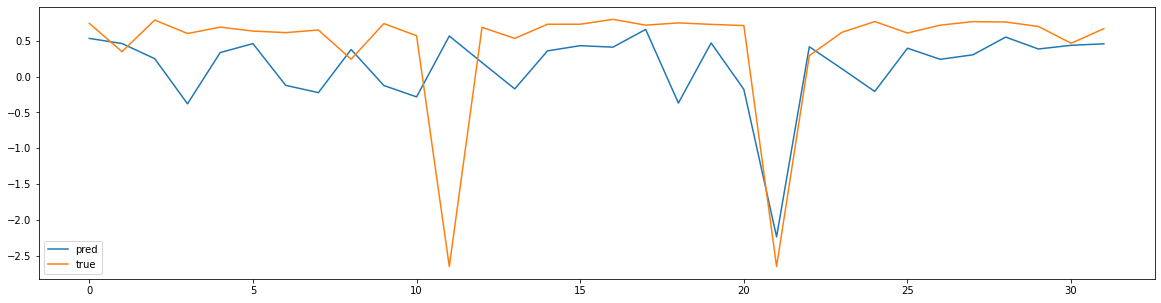

In [29]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

# A3GCN(cuda 문제)

In [7]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

In [9]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split


In [10]:
loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)


In [11]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(RecurrentGCN, self).__init__()
        self.recurrent = A3TGCN(node_features, 32, periods)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x.to("cuda:0").view(x.shape[0], 1, x.shape[1]), edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
model = RecurrentGCN(node_features = 1, periods = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

In [ ]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

# AGCRN

In [77]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [78]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=8)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [79]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features,number_of_nodes):
        super(RecurrentGCN, self).__init__()
        self.recurrent = AGCRN(number_of_nodes = 20,
                              in_channels = node_features,
                              out_channels = 2,
                              K = 2,
                              embedding_dimensions = 4)
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0

In [81]:
model = RecurrentGCN(node_features = 8,number_of_nodes=20)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

e = torch.empty(20, 4)

torch.nn.init.xavier_uniform_(e)

for epoch in tqdm(range(200)):
    cost = 0
    h = None
    for time, snapshot in enumerate(train_dataset):
        x = snapshot.x.view(1, 20, 8)
        y_hat, h = model(x, e, h)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


In [82]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    x = snapshot.x.view(1, 20, 8)
    y_hat, h = model(x, e, h)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.1426


# DCRNN

In [217]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [218]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [207]:
DCRNN?

Init signature: DCRNN(in_channels: int, out_channels: int, K: int, bias: bool = True)
Docstring:     
An implementation of the Diffusion Convolutional Gated Recurrent Unit.
For details see: `"Diffusion Convolutional Recurrent Neural Network:
Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Filter size :math:`K`.
    bias (bool, optional): If set to :obj:`False`, the layer
        will not learn an additive bias (default :obj:`True`)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/dcrnn.py
Type:           type
Subclasses:     


In [208]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [209]:
model = RecurrentGCN(node_features = 4)

In [210]:
model

RecurrentGCN(
  (recurrent): DCRNN(
    (conv_x_z): DConv(36, 32)
    (conv_x_r): DConv(36, 32)
    (conv_x_h): DConv(36, 32)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [41]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:52<00:00,  3.80it/s]


In [215]:
model.eval()
cost = 0
a=[]
a1=[]
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    a.append(cost)
cost = cost / (time+1)
a1.append(cost)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.1089


In [59]:
b = [a[i].detach() for i in range(len(a))]

In [65]:
test_dataset.snapshot_count

414

In [66]:
b[-1]/415

tensor(1.0354)

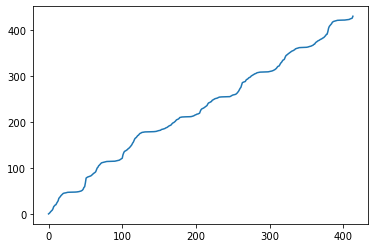

In [60]:
plt.plot(b)

# DYGRENCODER

In [150]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [151]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DyGrEncoder

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [152]:
DyGrEncoder?

Init signature:
DyGrEncoder(
    conv_out_channels: int,
    conv_num_layers: int,
    conv_aggr: str,
    lstm_out_channels: int,
    lstm_num_layers: int,
)
Docstring:     
An implementation of the integrated Gated Graph Convolution Long Short
Term Memory Layer. For details see this paper: `"Predictive Temporal Embedding
of Dynamic Graphs." <https://ieeexplore.ieee.org/document/9073186>`_

Args:
    conv_out_channels (int): Number of output channels for the GGCN.
    conv_num_layers (int): Number of Gated Graph Convolutions.
    conv_aggr (str): Aggregation scheme to use
        (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
    lstm_out_channels (int): Number of LSTM channels.
    lstm_num_layers (int): Number of neurons in LSTM.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/dygrae.py
Type:           type
Subclasses:     


In [201]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DyGrEncoder(conv_out_channels=4, conv_num_layers=1, conv_aggr="mean", lstm_out_channels=32, lstm_num_layers=1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        return h, h_0, c_0

In [202]:
model = RecurrentGCN(6)

In [203]:
model

RecurrentGCN(
  (recurrent): DyGrEncoder(
    (conv_layer): GatedGraphConv(4, num_layers=1)
    (recurrent_layer): LSTM(4, 32)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
cost = 0
h, c = None, None
for time, snapshot in enumerate(train_dataset):
    y_hat, h, c, i, j = model1(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    # h = F.relu(h)
    # # print(h.shape)
    # # h = self.linear(h)
    # # y_hat = y_hat.reshape(-1)
    print(y_hat.shape,h.shape, c.shape, i.shape, j.shape)

In [ ]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

In [76]:
model.eval()
cost = 0
h, c = None, None
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 2.2043


# EvolveGCNH

In [104]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [105]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [106]:
EvolveGCNH?

Init signature:
EvolveGCNH(
    num_of_nodes: int,
    in_channels: int,
    improved: bool = False,
    cached: bool = False,
    normalize: bool = True,
    add_self_loops: bool = True,
)
Docstring:     
An implementation of the Evolving Graph Convolutional Hidden Layer.
For details see this paper: `"EvolveGCN: Evolving Graph Convolutional
Networks for Dynamic Graph." <https://arxiv.org/abs/1902.10191>`_

Args:
    num_of_nodes (int): Number of vertices.
    in_channels (int): Number of filters.
    improved (bool, optional): If set to :obj:`True`, the layer computes
        :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
        (default: :obj:`False`)
    cached (bool, optional): If set to :obj:`True`, the layer will cache
        the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
        cached version for further executions.
        This parameter should only be set to :obj:`True` 

In [107]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_count, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = EvolveGCNH(node_count, node_features)
        self.linear = torch.nn.Linear(node_features, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [108]:
model = RecurrentGCN(node_features = 4, node_count = 20)


In [109]:
model

RecurrentGCN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(4, ratio=0.2, multiplier=1.0)
    (recurrent_layer): GRU(4, 4)
    (conv_layer): GCNConv_Fixed_W(4, 4)
  )
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

In [68]:
model = RecurrentGCN(node_features = 4, node_count = 20)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


In [69]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.0213


# EVOLVEGCNO

In [110]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [111]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNO

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)


In [112]:
EvolveGCNO?

Init signature:
EvolveGCNO(
    in_channels: int,
    improved: bool = False,
    cached: bool = False,
    normalize: bool = True,
    add_self_loops: bool = True,
)
Docstring:     
An implementation of the Evolving Graph Convolutional without Hidden Layer.
For details see this paper: `"EvolveGCN: Evolving Graph Convolutional
Networks for Dynamic Graph." <https://arxiv.org/abs/1902.10191>`_
Args:
    in_channels (int): Number of filters.
    improved (bool, optional): If set to :obj:`True`, the layer computes
        :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
        (default: :obj:`False`)
    cached (bool, optional): If set to :obj:`True`, the layer will cache
        the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
        cached version for further executions.
        This parameter should only be set to :obj:`True` in transductive
        learning scenarios. (default: :obj:`

In [113]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = EvolveGCNO(node_features)
        self.linear = torch.nn.Linear(node_features, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [114]:
model = RecurrentGCN(node_features = 4)

In [115]:
model

RecurrentGCN(
  (recurrent): EvolveGCNO(
    (recurrent_layer): GRU(4, 4)
    (conv_layer): GCNConv_Fixed_W(4, 4)
  )
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

In [61]:
model = RecurrentGCN(node_features = 4)
for param in model.parameters():
    param.retain_grad()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:24<00:00,  8.03it/s]


In [62]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    if time == 0:
        model.recurrent.weight = None
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.0144


# GCLSTM

In [ ]:
GCLSTM?

Init signature:
GCLSTM(
    in_channels: int,
    out_channels: int,
    K: int,
    normalization: str = 'sym',
    bias: bool = True,
)
Docstring:     
An implementation of the the Integrated Graph Convolutional Long Short Term
Memory Cell. For details see this paper: `"GC-LSTM: Graph Convolution Embedded LSTM
for Dynamic Link Prediction." <https://arxiv.org/abs/1812.04206>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Chebyshev filter size :math:`K`.
    normalization (str, optional): The normalization scheme for the graph
        Laplacian (default: :obj:`"sym"`):

        1. :obj:`None`: No normalization
        :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

        2. :obj:`"sym"`: Symmetric normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
        \mathbf{D}^{-1/2}`

        3. :obj:`"rw"`: Random-walk normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1}

In [116]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [56]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GCLSTM

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [57]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [58]:
model = RecurrentGCN(node_features=4)

In [59]:
model

RecurrentGCN(
  (recurrent): GCLSTM(
    (conv_i): ChebConv(32, 32, K=1, normalization=sym)
    (conv_f): ChebConv(32, 32, K=1, normalization=sym)
    (conv_c): ChebConv(32, 32, K=1, normalization=sym)
    (conv_o): ChebConv(32, 32, K=1, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [65]:
model = RecurrentGCN(node_features=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(100)): #200
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


In [66]:
model.eval()
cost = 0
_a=[]
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    y_hat.reshape(-1)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    _a.append(y_hat)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.9315


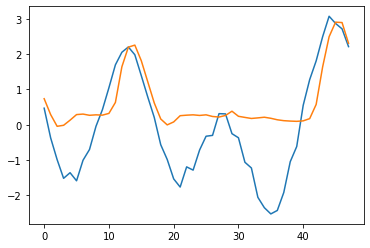

In [67]:
plt.plot([test_dataset.targets[i][0] for i in range(48)])
plt.plot(torch.tensor([_a[i].detach()[0] for i in range(48)]))

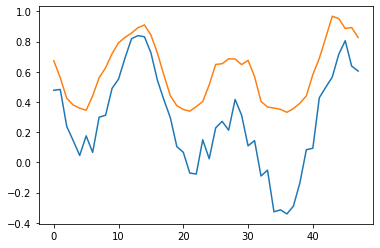

In [68]:
plt.plot([test_dataset.targets[i][1] for i in range(48)])
plt.plot(torch.tensor([_a[i].detach()[1] for i in range(48)]))

# GConvLSTM

In [53]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [54]:
# import torch
# import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM

# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [55]:
GConvLSTM?

Init signature:
GConvLSTM(
    in_channels: int,
    out_channels: int,
    K: int,
    normalization: str = 'sym',
    bias: bool = True,
)
Docstring:     
An implementation of the Chebyshev Graph Convolutional Long Short Term Memory
Cell. For details see this paper: `"Structured Sequence Modeling with Graph
Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    K (int): Chebyshev filter size :math:`K`.
    normalization (str, optional): The normalization scheme for the graph
        Laplacian (default: :obj:`"sym"`):

        1. :obj:`None`: No normalization
        :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

        2. :obj:`"sym"`: Symmetric normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
        \mathbf{D}^{-1/2}`

        3. :obj:`"rw"`: Random-walk normalization
        :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-

In [125]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [126]:
model = RecurrentGCN(node_features=4)

In [127]:
model

RecurrentGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(4, 32, K=1, normalization=sym)
    (conv_h_i): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_f): ChebConv(4, 32, K=1, normalization=sym)
    (conv_h_f): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_c): ChebConv(4, 32, K=1, normalization=sym)
    (conv_h_c): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_o): ChebConv(4, 32, K=1, normalization=sym)
    (conv_h_o): ChebConv(32, 32, K=1, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [35]:
model = RecurrentGCN(node_features=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [01:05<00:00,  3.03it/s]


In [48]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.7364


# Lightning(설치 안 됨)

In [ ]:
import torch
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

In [ ]:
class LitDiffConvModel(pl.LightningModule):

    def __init__(self, node_features, filters):
        super().__init__()
        self.recurrent = DCRNN(node_features, filters, 1)
        self.linear = torch.nn.Linear(filters, 1)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x = train_batch.x
        y = train_batch.y.view(-1, 1)
        edge_index = train_batch.edge_index
        h = self.recurrent(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        loss = F.mse_loss(h, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch.x
        y = val_batch.y.view(-1, 1)
        edge_index = val_batch.edge_index
        h = self.recurrent(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        loss = F.mse_loss(h, y)
        metrics = {'val_loss': loss}
        self.log_dict(metrics)
        return metrics

In [ ]:
loader = ChickenpoxDatasetLoader()

dataset_loader = loader.get_dataset(lags=32)

train_loader, val_loader = temporal_signal_split(dataset_loader,
                                                 train_ratio=0.2)

In [ ]:
model = LitDiffConvModel(node_features=32,
                         filters=16)

In [ ]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=0.00,
                                    patience=10,
                                    verbose=False,
                                    mode='max')

In [ ]:
trainer = pl.Trainer(callbacks=[early_stop_callback])

In [ ]:
trainer.fit(model, train_loader, val_loader)

# LRGCN

In [128]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [129]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import LRGCN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [130]:
LRGCN?

Init signature:
LRGCN(
    in_channels: int,
    out_channels: int,
    num_relations: int,
    num_bases: int,
)
Docstring:     
An implementation of the Long Short Term Memory Relational
Graph Convolution Layer. For details see this paper: `"Predicting Path
Failure In Time-Evolving Graphs." <https://arxiv.org/abs/1905.03994>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    num_relations (int): Number of relations.
    num_bases (int): Number of bases.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/lrgcn.py
Type:           type
Subclasses:     


In [131]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = LRGCN(node_features, 32, 1, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [132]:
model = RecurrentGCN(node_features = 4)

In [133]:
model

RecurrentGCN(
  (recurrent): LRGCN(
    (conv_x_i): RGCNConv(4, 32, num_relations=1)
    (conv_h_i): RGCNConv(32, 32, num_relations=1)
    (conv_x_f): RGCNConv(4, 32, num_relations=1)
    (conv_h_f): RGCNConv(32, 32, num_relations=1)
    (conv_x_c): RGCNConv(4, 32, num_relations=1)
    (conv_h_c): RGCNConv(32, 32, num_relations=1)
    (conv_x_o): RGCNConv(4, 32, num_relations=1)
    (conv_h_o): RGCNConv(32, 32, num_relations=1)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [40]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [01:10<00:00,  2.84it/s]


In [41]:
model.eval()
cost = 0
h, c = None, None
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.6055


# MPNNLSTM

In [72]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [73]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [74]:
MPNNLSTM?

Init signature:
MPNNLSTM(
    in_channels: int,
    hidden_size: int,
    num_nodes: int,
    window: int,
    dropout: float,
)
Docstring:     
An implementation of the Message Passing Neural Network with Long Short Term Memory.
For details see this paper: `"Transfer Graph Neural Networks for Pandemic Forecasting." <https://arxiv.org/abs/2009.08388>`_

Args:
    in_channels (int): Number of input features.
    hidden_size (int): Dimension of hidden representations.
    num_nodes (int): Number of nodes in the network.
    window (int): Number of past samples included in the input.
    dropout (float): Dropout rate.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/mpnn_lstm.py
Type:           type
Subclasses:     


In [75]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = MPNNLSTM(node_features, 32,  20, 1, 0.5) # 32, 32, 20, 1, 0.5 이었는데 position 잘못되었다해서 32하나 뺌
        self.linear = torch.nn.Linear(2*32 + node_features, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

In [83]:
model = RecurrentGCN(node_features = 2)

In [84]:
model

RecurrentGCN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(2, 32)
    (_convolution_2): GCNConv(32, 32)
    (_batch_norm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(64, 32)
    (_recurrent_2): LSTM(32, 32)
  )
  (linear): Linear(in_features=66, out_features=1, bias=True)
)

In [34]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.2776


# TGCN

In [135]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

In [136]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [137]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = TGCN(node_features, 32)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

In [142]:
TGCN?

Init signature:
TGCN(
    in_channels: int,
    out_channels: int,
    improved: bool = False,
    cached: bool = False,
    add_self_loops: bool = True,
)
Docstring:     
An implementation of the Temporal Graph Convolutional Gated Recurrent Cell.
For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_

Args:
    in_channels (int): Number of input features.
    out_channels (int): Number of output features.
    improved (bool): Stronger self loops. Default is False.
    cached (bool): Caching the message weights. Default is False.
    add_self_loops (bool): Adding self-loops for smoothing. Default is True.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torch_geometric_temporal/nn/recurrent/temporalgcn.py
Type:           type
Subclasses:     


In [138]:
model = RecurrentGCN(node_features = 4)


In [139]:
model

RecurrentGCN(
  (recurrent): TGCN(
    (conv_z): GCNConv(4, 32)
    (linear_z): Linear(in_features=64, out_features=32, bias=True)
    (conv_r): GCNConv(4, 32)
    (linear_r): Linear(in_features=64, out_features=32, bias=True)
    (conv_h): GCNConv(4, 32)
    (linear_h): Linear(in_features=64, out_features=32, bias=True)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [26]:
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    hidden_state = None
    for time, snapshot in enumerate(train_dataset):
        y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,hidden_state)
        y_hat = y_hat.reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


In [27]:
model.eval()
cost = 0
hidden_state = None
for time, snapshot in enumerate(test_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, hidden_state)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.0793
